In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

## Functions

In [96]:
brackets = {
    "0_35K": 17500,
    "35K_60K": 47500,
    "60K_100K": 80000,
    "100K_125K": 112500,
    "125K_150K": 137500,
    "150K_MORE": 150000
}

In [64]:
def plot_vote_share_vs_population(df, population_col, dem_col, rep_col, degree):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x=population_col,
        y=dem_col,
        color='blue',
        label='Democratic Vote Share',
        alpha=0.6
    )
    sns.scatterplot(
        data=df,
        x=population_col,
        y=rep_col,
        color='red',
        label='Republican Vote Share',
        alpha=0.6
    )

    democratic_poly = Polynomial.fit(df[population_col], df[dem_col], deg=degree)
    x_vals = np.linspace(df[population_col].min(), df[population_col].max(), 100)
    plt.plot(x_vals, democratic_poly(x_vals), color='blue', label='Democratic Line')

    republican_poly = Polynomial.fit(df[population_col], df[rep_col], deg=degree)
    plt.plot(x_vals, republican_poly(x_vals), color='red', label='Republican Line')

    # Customize plot
    plt.title('Non-Linear Vote Share vs Population Percentage', fontsize=16)
    plt.xlabel(f'{population_col}', fontsize=14)
    plt.ylabel('Vote Share', fontsize=14)
    plt.legend(title="Vote Share", fontsize=12)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

In [88]:
def calculate_avg_income(row):
    total_income = 0
    total_households = 0
    for bracket, midpoint in brackets.items():
        total_income += row[bracket] * midpoint
        total_households += row[bracket]
    return total_income / total_households if total_households > 0 else 0

In [100]:
def process_population_vote_share(race_df, election_df, region_type_df, econ_df, target_population_col_name, population_col):

    election_df['Republican_Vote_Share'] = (election_df['TOT_REP'] / election_df['TOT_VOT']) * 100
    election_df['Democratic_Vote_Share'] = (election_df['TOT_DEM'] / election_df['TOT_VOT']) * 100
    race_df[target_population_col_name] = (race_df[population_col] / race_df['TOT_POP22']) * 100
    econ_df['Avg_Household_Income'] = econ_df.apply(calculate_avg_income, axis=1)

    merged_df = pd.merge(election_df, race_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, region_type_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, econ_df, on='UNIQUE_ID', how='inner')

    columns_to_keep = ['UNIQUE_ID', 'Republican_Vote_Share', 'Democratic_Vote_Share', target_population_col_name, 'Avg_Household_Income', 'region_type']
    merged_df = merged_df[columns_to_keep]
    merged_df = merged_df.dropna(subset=[target_population_col_name, 'Democratic_Vote_Share', 'Republican_Vote_Share'])
    # remove 0.0 100.0 from the data
    merged_df = merged_df[(merged_df[target_population_col_name] != 0.0) & (merged_df[target_population_col_name] != 100.0)]
    merged_df = merged_df[(merged_df['Republican_Vote_Share'] != 0.0) & (merged_df['Republican_Vote_Share'] != 100.0)]
    merged_df = merged_df[(merged_df['Democratic_Vote_Share'] != 0.0) & (merged_df['Democratic_Vote_Share'] != 100.0)]
    return merged_df

## Import data

In [101]:
sc_election_gov_df = pd.read_json('states/south_carolina/election/sc_election_gov_22.json')
sc_race_df = pd.read_json('states/south_carolina/demographics/south_carolina_precincts_racial_population.json')
sc_region_type_df = pd.read_json('states/south_carolina/geodata/south_carolina_precincts_region_type.json')
sc_econ_df = pd.read_json('states/south_carolina/economic/south_carolina_precincts_household_income.json')

## Main script

In [91]:
print(sc_econ_df.head())

                 UNIQUE_ID          NAME  Prec_Code  CONG_DIST     MEDN_INC22  \
0  DORCHESTER_PRECINCT_084  BEECH HILL 2         84          1  147821.000000   
1  DORCHESTER_PRECINCT_072       CYPRESS         72          1   95882.529695   
2  DORCHESTER_PRECINCT_036      DELEMARS         36          1       0.000000   
3  DORCHESTER_PRECINCT_035       GIVHANS         35          1  101550.000000   
4  DORCHESTER_PRECINCT_094     GIVHANS 2         94          1   74970.000000   

   TOT_HOUS22  0_35K  35K_60K  60K_100K  100K_125K  125K_150K  150K_MORE  
0        1172     68       42       163        153        391        355  
1        1246    244      162       267        256        105        212  
2           0      0        0         0          0          0          0  
3         675     96       91       104        262         39         83  
4         437     38      120       123         55         21         80  


In [92]:
print(sc_election_gov_df.head())

                UNIQUE_ID  Prec_Code         Precinct  TOT_REP  TOT_DEM  \
0  ABBEVILLE_PRECINCT_001          1  ABBEVILLE NO. 1      718      257   
1  ABBEVILLE_PRECINCT_002          2  ABBEVILLE NO. 2      224      404   
2  ABBEVILLE_PRECINCT_003          3  ABBEVILLE NO. 3      336      238   
3  ABBEVILLE_PRECINCT_004          4  ABBEVILLE NO. 4      316      121   
4  ABBEVILLE_PRECINCT_005          5       ANTREVILLE      599      123   

   TOT_VOT        LEAN  
0      975  Republican  
1      628  Democratic  
2      574  Republican  
3      437  Republican  
4      722  Republican  


In [93]:
print(sc_race_df.head())

                 UNIQUE_ID          NAME  Prec_Code  CONG_DIST  TOT_POP22  \
0  DORCHESTER_PRECINCT_084  BEECH HILL 2         84          1       3569   
1  DORCHESTER_PRECINCT_072       CYPRESS         72          1       3916   
2  DORCHESTER_PRECINCT_036      DELEMARS         36          1          0   
3  DORCHESTER_PRECINCT_035       GIVHANS         35          1       2057   
4  DORCHESTER_PRECINCT_094     GIVHANS 2         94          1       1558   

   NHSP_POP22  HSP_POP22  WHT_NHSP22  BLK_NHSP22  AIA_NHSP22  ASN_NHSP22  \
0        3482         87        3482           0           0           0   
1        3760        156        2661         772           0          19   
2           0          0           0           0           0           0   
3        2039         18        1234         528          12           0   
4        1541         17         837         456           0           0   

   HPI_NHSP22  OTH_NHSP22  
0           0           0  
1           0         30

In [102]:
white_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'White_Pop_Percent', 'WHT_NHSP22')
black_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'Black_Pop_Percent', 'BLK_NHSP22')
asian_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'Asian_Pop_Percent', 'ASN_NHSP22')
hispanic_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'Hispanic_Pop_Percent', 'HPI_NHSP22')


In [103]:
print(white_pop_vote_share_df.head())

                UNIQUE_ID  Republican_Vote_Share  Democratic_Vote_Share  \
0  ABBEVILLE_PRECINCT_001              73.641026              26.358974   
1  ABBEVILLE_PRECINCT_002              35.668790              64.331210   
2  ABBEVILLE_PRECINCT_003              58.536585              41.463415   
3  ABBEVILLE_PRECINCT_004              72.311213              27.688787   
4  ABBEVILLE_PRECINCT_005              82.963989              17.036011   

   White_Pop_Percent  Avg_Household_Income region_type  
0          64.573643          77154.166667       rural  
1           8.879023          39623.842593       rural  
2          48.188126          50532.928943       rural  
3          63.217391          66791.831357       rural  
4          84.858569          76699.751861       rural  


In [104]:
# Convert df to lists of dictionaries
white_pop_vote_share_list = white_pop_vote_share_df.to_dict(orient='records')
black_pop_vote_share_list = black_pop_vote_share_df.to_dict(orient='records')
asian_pop_vote_share_list = asian_pop_vote_share_df.to_dict(orient='records')
hispanic_pop_vote_share_list = hispanic_pop_vote_share_df.to_dict(orient='records')

output_data = {
    "election": "2022 Gubernatorial Elections",
    "data": {
        "White": white_pop_vote_share_list,
        "Black": black_pop_vote_share_list,
        "Asian": asian_pop_vote_share_list,
        "Hispanic": hispanic_pop_vote_share_list
    }
}

output_json = json.dumps(output_data, indent=4)
open ('states/south_carolina/gingles/sc_gingles_precinct_analysis.json', 'w').write(output_json)

1785873

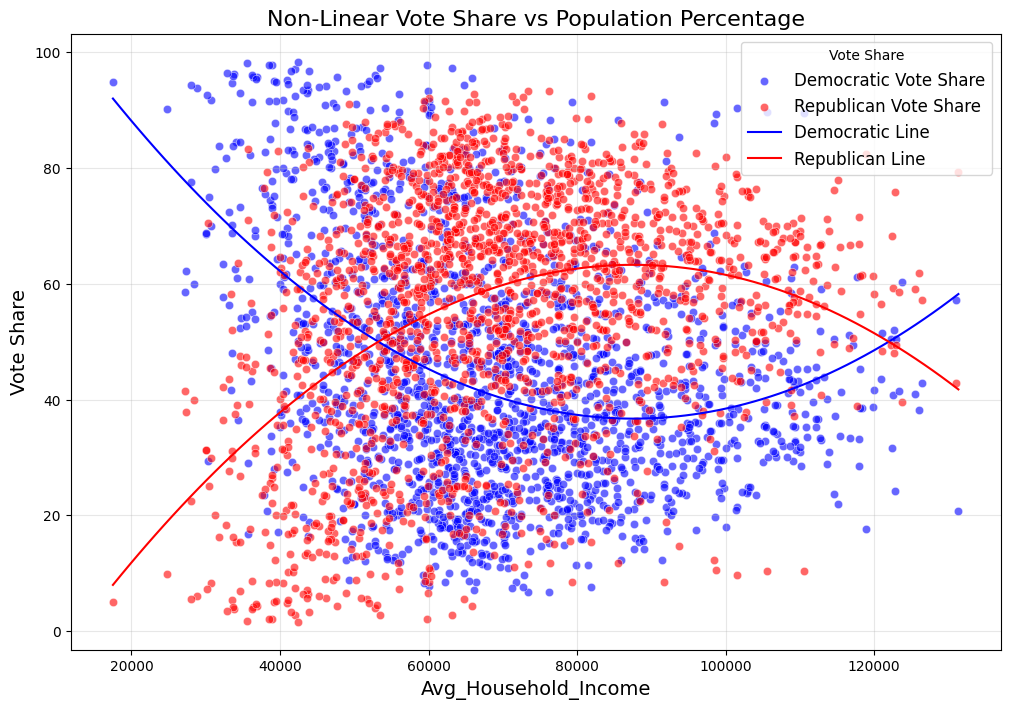

In [108]:
plot_vote_share_vs_population(
    df=black_pop_vote_share_df,
    population_col='Avg_Household_Income',
    dem_col='Democratic_Vote_Share',
    rep_col='Republican_Vote_Share',
    degree=2
)